<a href="https://colab.research.google.com/github/qkrdudwls/Bible-vs-Quran/blob/main/DM_TextRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Mining Project**

## Overview
- Bible과 Quran을 chapter 별로 나누어서 crawling
- TF-IDF를 이용하여 Bible과 Quran의 Word Cloud 생성
- TextRank 알고리즘을 이용하여 keyword 추출 및 문장 요약
- 요약된 문장을 바탕으로 Cosine Similarity와 Jaccard Similarity 계산


---------------

## Set up

### 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Selenium & chromedriver 설치

In [ ]:
!pip install selenium
!apt-get update

!apt install chromium-chromedriver
!cp /usr/bin/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

### Spark 설치

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u432-ga~us1-0ubuntu2~22.04).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


### NLTK & NetworkX 설치

In [ ]:
!pip install nltk
!pip install networkx

#### Version 확인

In [ ]:
!python --version

import selenium
import pyspark
import nltk
import networkx

print(f"Selenium {selenium.__version__}")
print(f"PySpark {pyspark.__version__}")
print(f"NLTK {nltk.__version__}")
print(f"NetworkX {networkx.__version__}")

Python 3.10.12
Selenium 4.26.1
PySpark 3.5.3
NLTK 3.9.1
NetworkX 3.4.2


### Import Library

In [ ]:
# Crawling
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller
import re

import glob
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.sql.functions import col, explode, udf, lower, regexp_replace
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DoubleType
from pyspark.ml.linalg import SparseVector
import spacy
import nltk

import networkx as nx
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from itertools import combinations

### chrome_options 설정

In [ ]:
chrome_path="/content/drive/Mydrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

chromedriver_autoinstaller.install()

## Crawling

### 데이터 전처리 함수
- 영어 알파벳과 공백만 제외하고 모두 제거
- 모든 문자를 소문자로 변환
- 연속된 공백을 단일 공백으로 축소
- 양 끝의 공백 제거

In [ ]:
def preprocess_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text.strip()

### Bible

In [ ]:
# URL과 웹 드라이버 설정
url = 'https://www.gutenberg.org/cache/epub/10/pg10-images.html'
driver = webdriver.Chrome(options=chrome_options)
driver.get(url)

# 최대 10초 대기
wait = WebDriverWait(driver, 10)

# bible_texts 폴더가 없으면 생성
output_folder = "bible_texts"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

try:
    # 모든 'chapter' 클래스 div 요소 찾기
    chapter_divs = driver.find_elements(By.CLASS_NAME, "chapter")

    # 첫 번째 div는 건너뛰고 두 번째 div부터 순회 (첫 번째 div는 제목)
    for index, chapter_div in enumerate(chapter_divs[1:], start=2):
        # 텍스트 추출 및 전처리 (영어만 남기기)
        chapter_text = chapter_div.get_attribute("textContent")
        chapter_text = preprocess_text(chapter_text)  # 전처리 함수 적용
        chapter_text = chapter_text.strip()  # 앞뒤 공백 제거

        # 파일로 저장
        if chapter_text:  # 내용이 있을 경우에만 저장
            filename = os.path.join(output_folder, f"chapter_{index-1}.txt")
            with open(filename, "w", encoding="utf-8") as file:
                file.write(chapter_text)
            print(f"Saved text from div #{index-1} to {filename}")

except Exception as e:
    print("Error:", e)

finally:
    # 드라이버 종료
    driver.quit()

Saved text from div #1 to bible_texts/chapter_1.txt
Saved text from div #2 to bible_texts/chapter_2.txt
Saved text from div #3 to bible_texts/chapter_3.txt
Saved text from div #4 to bible_texts/chapter_4.txt
Saved text from div #5 to bible_texts/chapter_5.txt
Saved text from div #6 to bible_texts/chapter_6.txt
Saved text from div #7 to bible_texts/chapter_7.txt
Saved text from div #8 to bible_texts/chapter_8.txt
Saved text from div #9 to bible_texts/chapter_9.txt
Saved text from div #10 to bible_texts/chapter_10.txt
Saved text from div #11 to bible_texts/chapter_11.txt
Saved text from div #12 to bible_texts/chapter_12.txt
Saved text from div #13 to bible_texts/chapter_13.txt
Saved text from div #14 to bible_texts/chapter_14.txt
Saved text from div #15 to bible_texts/chapter_15.txt
Saved text from div #16 to bible_texts/chapter_16.txt
Saved text from div #17 to bible_texts/chapter_17.txt
Saved text from div #18 to bible_texts/chapter_18.txt
Saved text from div #19 to bible_texts/chapter

### Quran

In [ ]:
# URL과 웹 드라이버 설정
url = 'https://www.gutenberg.org/cache/epub/2800/pg2800-images.html'
driver = webdriver.Chrome(options=chrome_options)
driver.get(url)

wait = WebDriverWait(driver, 10)  # 최대 10초 대기

# 저장할 폴더 생성
output_dir = 'quran_texts'
os.makedirs(output_dir, exist_ok=True)

current_document = []  # 현재 문서의 텍스트를 저장할 리스트
chapter_count = 1  # 챕터 카운터
start_crawling = False  # 첫 번째 <h4> 이후 크롤링 시작

try:
    # 페이지의 모든 태그를 순서대로 가져옴
    elements = driver.find_elements(By.XPATH, "//*[name()='h4' or name()='p' or @id='pg-end-separator']")

    for element in elements:
        # 크롤링 종료 조건: <div id="pg-end-separator"> 발견 시
        if element.tag_name == 'div' and element.get_attribute('id') == 'pg-end-separator':
            break

        # 첫 번째 <h4> 이후 크롤링 시작
        if element.tag_name == 'h4':
            start_crawling = True  # 첫 번째 <h4> 발견 시 True로 설정

            if current_document:  # 현재 문서가 비어있지 않다면 데이터를 파일로 저장
                # 전처리 및 병합
                quran_processed_text = ' '.join(preprocess_text(' '.join(current_document)).split())

                # 파일 저장
                with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
                    file.write(quran_processed_text)

                print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")  # 진행 상황 출력

                chapter_count += 1  # 챕터 카운트 증가
                current_document = []  # 새로운 문서 시작을 위해 초기화

        # <p> 태그의 텍스트 수집
        if start_crawling and element.tag_name == 'p':
            quran_text = preprocess_text(element.text.strip())
            current_document.append(quran_text)

    # 마지막 문서 저장
    if current_document:
        quran_processed_text = ' '.join(preprocess_text(' '.join(current_document)).split())
        with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
            file.write(quran_processed_text)
        print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")  # 마지막 챕터 저장 출력

except Exception as e:
    print("Error:", e)

finally:
    # 드라이버 종료
    driver.quit()


Saved chapter 1 to quran_texts/chapter_1.txt
Saved chapter 2 to quran_texts/chapter_2.txt
Saved chapter 3 to quran_texts/chapter_3.txt
Saved chapter 4 to quran_texts/chapter_4.txt
Saved chapter 5 to quran_texts/chapter_5.txt
Saved chapter 6 to quran_texts/chapter_6.txt
Saved chapter 7 to quran_texts/chapter_7.txt
Saved chapter 8 to quran_texts/chapter_8.txt
Saved chapter 9 to quran_texts/chapter_9.txt
Saved chapter 10 to quran_texts/chapter_10.txt
Saved chapter 11 to quran_texts/chapter_11.txt
Saved chapter 12 to quran_texts/chapter_12.txt
Saved chapter 13 to quran_texts/chapter_13.txt
Saved chapter 14 to quran_texts/chapter_14.txt
Saved chapter 15 to quran_texts/chapter_15.txt
Saved chapter 16 to quran_texts/chapter_16.txt
Saved chapter 17 to quran_texts/chapter_17.txt
Saved chapter 18 to quran_texts/chapter_18.txt
Saved chapter 19 to quran_texts/chapter_19.txt
Saved chapter 20 to quran_texts/chapter_20.txt
Saved chapter 21 to quran_texts/chapter_21.txt
Saved chapter 22 to quran_texts

## TextRank
- Bible과 Qur'an의 키워드 추출 및 문장 요약


### Bible

In [ ]:
# Spark 세션 생성
spark = SparkSession.builder.appName("TextRank Summary of the Bible").getOrCreate()

# 크롤링한 텍스트 파일 로드 (각 챕터를 별도의 행으로 저장)
data_dir = "/content/bible_texts"  # 크롤링한 텍스트 파일이 저장된 디렉터리 경로
text_files = [(file, open(os.path.join(data_dir, file), "r", encoding="utf-8").read()) for file in os.listdir(data_dir) if file.endswith(".txt")]
df = spark.createDataFrame(text_files, ["filename", "text"])

# TextRank 알고리즘 함수 정의
def textrank_summary_and_keywords(text):
    # 문장 및 단어 토큰화
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    # TF-IDF 임베딩 생성
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    # 코사인 유사도로 유사도 행렬 생성
    similarity_matrix = cosine_similarity(sentence_vectors)

    # 그래프 생성 및 PageRank 계산
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # 상위 3개 문장을 요약으로 추출
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([ranked_sentences[i][1] for i in range(min(3, len(ranked_sentences)))])

    # 상위 10개 키워드 추출
    keywords = " ".join(sorted(set(words), key=words.count, reverse=True)[:10])

    return summary, keywords

# UDF로 TextRank 요약 및 키워드 추출 함수 등록
textrank_udf = udf(lambda text: textrank_summary_and_keywords(text)[0], StringType())
keywords_udf = udf(lambda text: textrank_summary_and_keywords(text)[1], StringType())

# DataFrame에 요약과 키워드 컬럼 추가
df = df.withColumn("summary", textrank_udf(df.text))
df = df.withColumn("keywords", keywords_udf(df.text))

# 요약 및 키워드 결과를 pandas DataFrame으로 변환
result_df = df.select("filename", "summary", "keywords").toPandas()

# 요약된 문장을 bible_summary.txt 파일로 저장
with open("bible_summary.txt", "w") as file:
    for index, row in result_df.iterrows():
        summary_text = f"Filename: {row['filename']}\nSummary: {row['summary']}\n"
        file.write(summary_text + "\n")  # 파일에 저장

# Spark 세션 종료
spark.stop()

### Quran

In [ ]:
# Spark 세션 생성
spark = SparkSession.builder.appName("TextRank Summary of the Quran").getOrCreate()

# 크롤링한 텍스트 파일 로드 (각 챕터를 별도의 행으로 저장)
data_dir = "/content/quran_texts"  # 크롤링한 텍스트 파일이 저장된 디렉터리 경로
text_files = [(file, open(os.path.join(data_dir, file), "r", encoding="utf-8").read()) for file in os.listdir(data_dir) if file.endswith(".txt")]
df = spark.createDataFrame(text_files, ["filename", "text"])

# TextRank 알고리즘 함수 정의
def textrank_summary_and_keywords(text):
    # 문장 및 단어 토큰화
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    # TF-IDF 임베딩 생성
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    # 코사인 유사도로 유사도 행렬 생성
    similarity_matrix = cosine_similarity(sentence_vectors)

    # 그래프 생성 및 PageRank 계산
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # 상위 3개 문장을 요약으로 추출
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([ranked_sentences[i][1] for i in range(min(3, len(ranked_sentences)))])

    # 상위 10개 키워드 추출
    keywords = " ".join(sorted(set(words), key=words.count, reverse=True)[:10])

    return summary, keywords

# UDF로 TextRank 요약 및 키워드 추출 함수 등록
textrank_udf = udf(lambda text: textrank_summary_and_keywords(text)[0], StringType())
keywords_udf = udf(lambda text: textrank_summary_and_keywords(text)[1], StringType())

# DataFrame에 요약과 키워드 컬럼 추가
df = df.withColumn("summary", textrank_udf(df.text))
df = df.withColumn("keywords", keywords_udf(df.text))

# 요약 및 키워드 결과를 pandas DataFrame으로 변환
result_df = df.select("filename", "summary", "keywords").toPandas()

# 요약된 문장을 quran_summary.txt 파일로 저장
with open("quran_summary.txt", "w") as file:
    for index, row in result_df.iterrows():
        summary_text = f"Filename: {row['filename']}\nSummary: {row['summary']}\n"
        file.write(summary_text + "\n")  # 파일에 저장

spark.stop()

## Similarity
- bible_summary.txt와 quran_summary.txt를 사용하여 Bible과 Quran의 유사도 계산

### Cosine Similarity & Jaccard Similarity

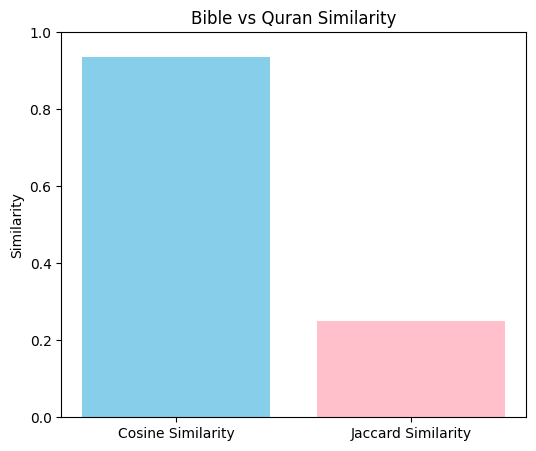

Similarity
Cosine: 0.9344941661589431
Jaccard: 0.25122222222222224


Similarity (Percentage)
Cosine:93.44941661589431%
Jaccard:25.122222222222224%


In [ ]:
# Spark 세션 생성
spark = SparkSession.builder.appName("Bible vs Quran Similarity").getOrCreate()

# 요약 파일 로드
data_dir = "/content"  # 텍스트 파일이 저장된 디렉터리 경로
files = [("bible", open(os.path.join(data_dir, "bible_summary.txt"), "r", encoding="utf-8").read()),
         ("quran", open(os.path.join(data_dir, "quran_summary.txt"), "r", encoding="utf-8").read())]
df = spark.createDataFrame(files, ["text_id", "text"])

# 텍스트 데이터 수집
texts = [row.text for row in df.collect()]

# 코사인 유사도 계산
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

# 자카드 유사도 계산 함수 정의
def jaccard_similarity(text1, text2):
    words_text1 = set(text1.split())
    words_text2 = set(text2.split())
    intersection = words_text1.intersection(words_text2)
    union = words_text1.union(words_text2)
    return float(len(intersection)) / len(union)

# 자카드 유사도 계산
jaccard_sim = jaccard_similarity(texts[0], texts[1])

# 유사도 시각화
labels = ['Cosine Similarity', 'Jaccard Similarity']
similarities = [cosine_sim, jaccard_sim]

# 그래프 그리기
plt.figure(figsize=(6, 5))
plt.bar(labels, similarities, color=['skyblue', 'pink'])
plt.ylim(0, 1)
plt.ylabel('Similarity')
plt.title("Bible vs Quran Similarity")
plt.show()

print("Similarity")
print(f"Cosine: {cosine_sim}")
print(f"Jaccard: {jaccard_sim}")
print("\n")
print("Similarity (Percentage)")
print(f"Cosine:{cosine_sim*100}%")
print(f"Jaccard:{jaccard_sim*100}%")
# Spark 세션 종료
spark.stop()